In [1]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform
import torchvision.models as models
import timm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

from PIL import Image, ImageOps, ImageEnhance
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Load

In [2]:
all_img_list = glob.glob('./train/*/*')

df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : x.split('\\')[1])

df

,img_path,label
0,./train\가구수정\0.png,가구수정
1,./train\가구수정\1.png,가구수정
2,./train\가구수정\10.png,가구수정
3,./train\가구수정\11.png,가구수정
4,./train\가구수정\12.png,가구수정
...,...,...
4914,./train\훼손\995.png,훼손
4915,./train\훼손\996.png,훼손
4916,./train\훼손\997.png,훼손
4917,./train\훼손\998.png,훼손


## Split train set and valid set

In [3]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=0)

## Label encoding

19가지 하자유형을 숫자로 바꾼다.

In [4]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

train['label']

1252     5
2641    11
4114    18
1194     5
2674    11
        ..
4767    18
1950    10
978      3
2511    11
684      3
Name: label, Length: 3443, dtype: int32

## Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.img_path_list[index]

        image = Image.open(img_path)
        image = np.array(image)

        if self.transforms is not None:
            image = self.transforms(image=image)['image']
            image = image.float()

        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)

## Augmix

모델의 Robustness를 향상시키기 위해 Random Augmix 기법을 도입하여 모든 이미지에 기본적으로 적용시켜 학습에 사용한다.

### Augmix function 정의

In [6]:
def int_parameter(level, maxval):
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    return image - 127

def apply_op(image, op, severity):
    pil_img = Image.fromarray(image)
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    ws = np.float32(np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        mix += ws[i] * image_aug

    mixed = (1 - m) * image + m * mix
    return mixed

class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image

## Transform

모든 이미지의 사이즈를 224,224로 재설정하고 색상 값을 Normalize한다. Train set에는 위에서 정의한 RandomAugMix를 추가한다.

In [8]:
train_transform = A.Compose([
    A.Resize(224, 224),
    RandomAugMix(severity=4, width=3, alpha=1.0, p=0.7),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False,
                p=1.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False,
                p=1.0),
    ToTensorV2()
])

## Dataset and loader

In [10]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

## Model

모델은 timm에서 제공하는 이미지 모델인 resnet18을 사용한다.

In [11]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.model = timm.create_model('resnet18', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

## Train

In [16]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    EPOCHS = 20

    best_score = 0
    best_model = None
    patience_check = 0

    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad()

            output = model(imgs)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)

        if scheduler is not None:
            scheduler.step(_val_score)

        if best_score < _val_score:
            best_score = _val_score
            best_model = model
        else:
            if patience_check == 2:
                break
            else:
                patience_check += 1

        _train_loss = np.mean(train_loss)
        print(
            f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
        
    return best_model

## Validation

In [13]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device).long()

            pred = model(imgs)

            loss = criterion(pred, labels)

            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()

            val_loss.append(loss.item())

        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')

    return _val_loss, _val_score

## Run

In [17]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [1], Train Loss : [2.23679] Val Loss : [1.68081] Val Weighted F1 Score : [0.39905]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [2], Train Loss : [1.45807] Val Loss : [1.17261] Val Weighted F1 Score : [0.57568]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [3], Train Loss : [1.04979] Val Loss : [0.91291] Val Weighted F1 Score : [0.68848]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.78376] Val Loss : [0.74117] Val Weighted F1 Score : [0.76579]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.56472] Val Loss : [0.59521] Val Weighted F1 Score : [0.81060]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.41897] Val Loss : [0.54196] Val Weighted F1 Score : [0.82268]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.32075] Val Loss : [0.47162] Val Weighted F1 Score : [0.84091]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.25125] Val Loss : [0.47335] Val Weighted F1 Score : [0.84278]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.20019] Val Loss : [0.45794] Val Weighted F1 Score : [0.85346]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.16080] Val Loss : [0.46556] Val Weighted F1 Score : [0.85072]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.14967] Val Loss : [0.48441] Val Weighted F1 Score : [0.85080]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.14641] Val Loss : [0.44220] Val Weighted F1 Score : [0.85794]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.11364] Val Loss : [0.46939] Val Weighted F1 Score : [0.86439]


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

## Test

In [19]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

test = pd.read_csv('./test.csv')
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

preds = inference(infer_model, test_loader, device)
submit = pd.read_csv('./sample_submission.csv')
submit['label'] = preds
submit.to_csv('./submission.csv', index=False)

  0%|          | 0/25 [00:00<?, ?it/s]

## Submission

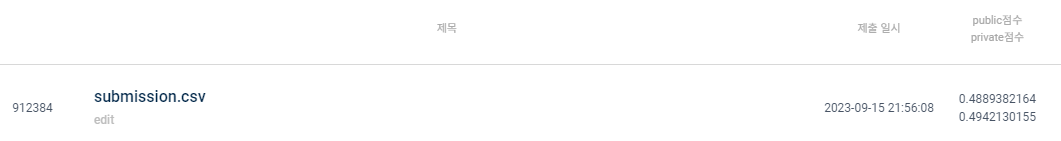

리더보드의 스코어는 f1 score이며 f1 score = 2 * ((Precision * Recall) / (Precision + Recall)) 이다.
Precision는 True라고 분류한 것 중 실제 True인 것의 비율이며 Recall은 실제 True인 것 중 모델이 True라고 분류한 것의 비율이다.